Agora que já foi feita a comparação simples inicial, vou aprofundar nas opções de preprocessamento

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [21]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [23]:
coluna_target=['median_house_value']

coluna_one_hot_encoder=['ocean_proximity']

coluna_ordinal_encoder=['median_income_cat']


In [24]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_standard_scaler=['longitude', 'latitude', 'housing_median_age']

colunas_power_transformer =  df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard_scaler)

Teste do melhor escalonamento para o modelo.

Test of the best scaling of the model

In [25]:
preprocessamento_categoricas =  ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
    ],
    remainder='passthrough' #todas as demais colunas sem alteração
)
preprocessamento_simples =  ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler', RobustScaler(), colunas_robust_scaler),
    ],
)
    #tirar o remainder porque o ribustscaler vai passar por todas as colunas
preprocessamento_completo =  ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler',  RobustScaler(), colunas_standard_scaler),
        ('satandard_scaler', StandardScaler(), colunas_power_transformer),
    ],
)

In [26]:
X=df.drop(columns=coluna_target)
y=df[coluna_target]

In [27]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [28]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [30]:
param_grid = {
    'regressor__preprocessor': [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo],
    'transformer':[None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

In [31]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento_completo,
    target_transformer=PowerTransformer(),
    param_grid=param_grid,
)
grid_search    

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler',
                                                                                                              RobustScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [32]:
grid_search.fit(X,y)   

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler',
                                                                                                              RobustScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [33]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('one_hot', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

o  robust scaler apenas teve um resultado melhor que

In [34]:
grid_search.best_score_

-54409.67625427238

In [35]:
coefs=dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

In [36]:
coefs

,coeficiente
robust_scaler__latitude,-1.074350
robust_scaler__longitude,-1.061448
one_hot__ocean_proximity_INLAND,-0.452983
robust_scaler__population_per_household,-0.233571
one_hot__ocean_proximity_NEAR BAY,-0.202861
robust_scaler__total_rooms,-0.100238
robust_scaler__total_bedrooms,-0.077858
one_hot__ocean_proximity_NEAR OCEAN,-0.060344
robust_scaler__population,-0.031483
ordinal_encoder__median_income_cat,0.036015


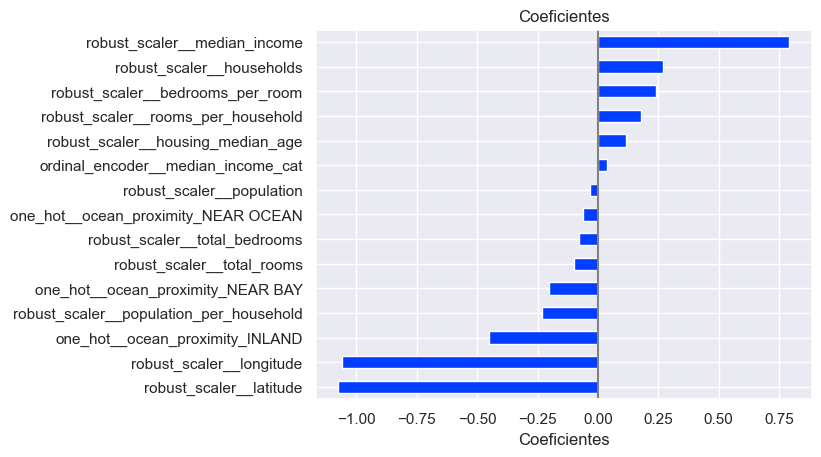

In [37]:
plot_coeficientes(coefs)

In [39]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
  
    'LinnearRegression_grid_search':{
        'preprocessor':grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer':grid_search.best_estimator_.transformer,
    },
}    
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.007676,0.007154,-0.000081,-77516.042766,-96239.705692,0.01483
1,DummyRegressor,0.005632,0.006024,-0.000146,-75787.787194,-95217.629397,0.011656
2,DummyRegressor,0.004395,0.006273,-0.001737,-76753.598961,-96253.253947,0.010669
3,DummyRegressor,0.00309,0.005923,-0.000101,-76837.804811,-95983.885799,0.009013
4,DummyRegressor,0.004855,0.004504,-0.000114,-76617.245449,-96182.764729,0.009359
5,LinnearRegression,0.03329,0.014483,0.682162,-39855.690921,-54254.958115,0.047773
6,LinnearRegression,0.021504,0.012468,0.66999,-40272.565406,-54695.230224,0.033972
7,LinnearRegression,0.023542,0.011183,0.649247,-42178.059246,-56955.988686,0.034725
8,LinnearRegression,0.017107,0.01039,0.669873,-40806.492452,-55146.31876,0.027497
9,LinnearRegression,0.026205,0.014058,0.669023,-40788.496555,-55331.351171,0.040263


In [41]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00513,0.005976,-0.000436,-76702.495836,-95975.447913,0.011105
LinnearRegression,0.02433,0.012516,0.668059,-40780.260916,-55276.769391,0.036846
LinnearRegression_grid_search,0.057327,0.014591,0.678173,-38675.418375,-54424.123569,0.071918


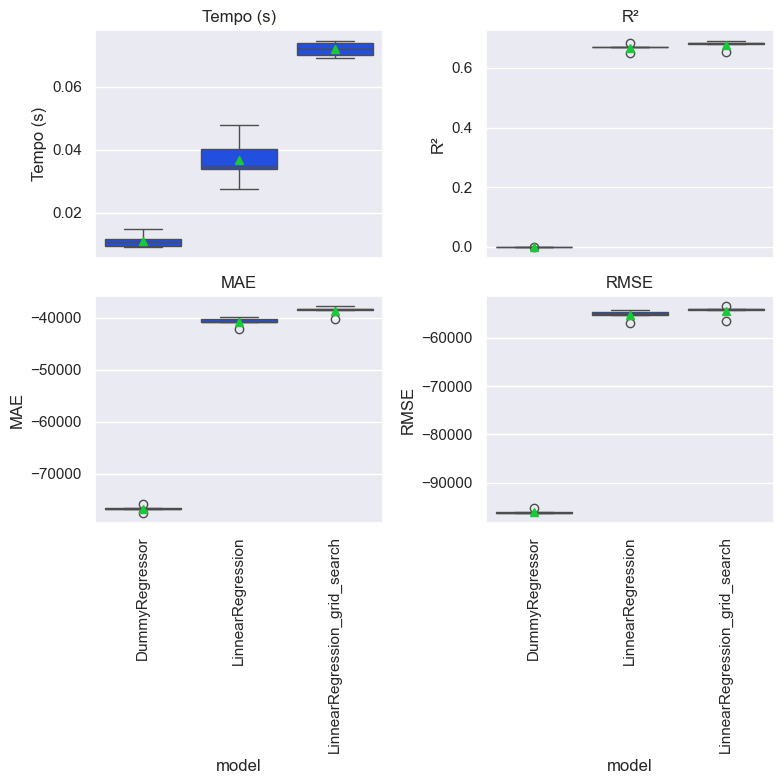

In [42]:
#o linear_regression teve um resultado melhor
plot_comparar_metricas_modelos(df_resultados)

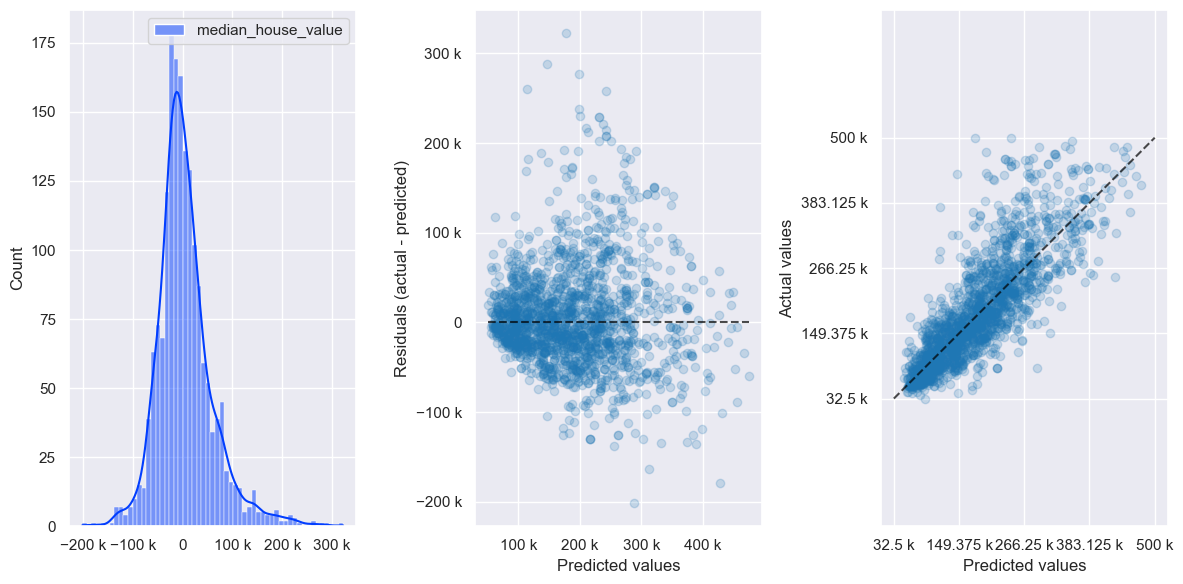

In [43]:
plot_residuos_estimador(grid_search.best_estimator_, X,y, fracao_amostra=0.1, eng_formatter=True)

Conclusão: O RobustScaler se mostrou uma melhor escolha, uma vez que normaliza os dados usando a mediana e o intervalo interquartil (IQR), o que torna o escalonamento robusto a outliers.

Conclusion: RobustScaler proved to be a better choice, as it normalizes the data using the median and interquartile range (IQR), which makes the scaling robust to outliers.